In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from functools import partial
sys.path.append('../../')

import jax
import jax.numpy as jnp
from ml_collections import ConfigDict
import matplotlib.pyplot as plt
from matplotlib import colormaps


from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.data_processing import butterfly_amasina_pts, butterfly_honrathi_pts
from sdebridge.utils import eval_score

2024-01-29 16:36:32.606151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 16:36:32.606181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 16:36:32.607230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 16:36:33.990582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

### Circles

In [3]:
def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: jnp.ndarray = jnp.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, n_samples, endpoint=False)
    x = a * jnp.cos(theta)
    y = b * jnp.sin(theta)
    return scale * jnp.stack([x, y], axis=1) + shifts[None, :]

S0 shape:  (64, 2)
ST shape:  (64, 2)
S0_eval shape:  (4, 2)
X0 shape:  (4, 2)
XT shape:  (4, 2)
XT shape (Padded):  (64, 2)


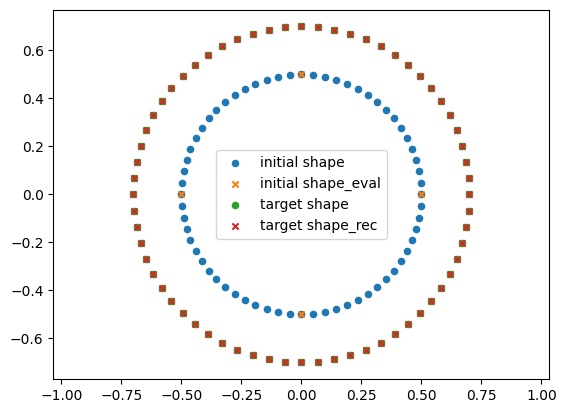

In [4]:
n_samples = 64
n_bases = 4

S0 = sample_ellipse(n_samples, scale=0.5)
ST = sample_ellipse(n_samples, scale=0.7)
print("S0 shape: ", S0.shape)
print("ST shape: ", ST.shape)

sde_config = ConfigDict(
    {
        'init_S': S0,
        'n_bases': n_bases,
        'n_grid': 50,
        'grid_range': [-1.5, 1.5],
        'alpha': 0.1,
        'sigma': 0.2,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)
S0_eval = sde.evaluate_S(sde.init_S)
print("S0_eval shape: ", S0_eval.shape)

X0 = jnp.zeros((sde.n_bases, 2), dtype=jnp.complex64)
print("X0 shape: ", X0.shape)
XT_eval = ST - S0
XT = jnp.fft.fft(XT_eval, norm="ortho", n=sde.n_samples, axis=0)
XT = jnp.fft.fftshift(XT, axes=0)
XT = XT[(sde.n_samples-sde.n_bases)//2:(sde.n_samples+sde.n_bases)//2, :]
print("XT shape: ", XT.shape)
XT_pad = jnp.pad(XT, ((sde.n_padding, sde.n_padding), (0, 0)))
print("XT shape (Padded): ", XT_pad.shape) 
XT_pad = jnp.fft.ifftshift(XT_pad, axes=0)
XT_rec = jnp.fft.ifft(XT_pad, norm="ortho", n=sde.n_samples, axis=0).real
ST_rec = XT_rec + S0

with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(S0[:, 0], S0[:, 1], s=20, label='initial shape')
    plt.scatter(S0_eval[:, 0].real, S0_eval[:, 1].real, s=20, marker='x', label='initial shape_eval')
    plt.scatter(ST[:, 0], ST[:, 1], s=20, label='target shape')
    plt.scatter(ST_rec[:, 0], ST_rec[:, 1], s=20, marker='x', label='target shape_rec')
    plt.legend()
    plt.axis('equal')
    plt.show()

In [5]:
X0_flatten = jnp.concatenate((X0[:, 0], X0[:, 1]), axis=0)
XT_flatten = jnp.concatenate((XT[:, 0], XT[:, 1]), axis=0)
print("X0_flatten shape: ", X0_flatten.shape)
print("XT_flatten shape: ", XT_flatten.shape)
forward_uncond = bridge.simulate_forward_process(
    initial_val = X0_flatten,
    num_batches = 4
)

X0_flatten shape:  (8,)
XT_flatten shape:  (8,)


In [6]:
Xs_flatten = forward_uncond["trajectories"]
print("Xs_flatten shape: ", Xs_flatten.shape)
Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
print("Xs shape: ", Xs.shape)
Xs_pad = jnp.pad(Xs, pad_width=((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs shape (padded): ", Xs_pad.shape)
Xs_pad = jnp.fft.ifftshift(Xs_pad, axes=-2)
Xs_rec = jnp.fft.ifft(Xs_pad, norm="ortho", n=n_samples, axis=-2)
print("Xs_rec shape: ", Xs_rec.shape)

Ss = S0[None, None, :, :] + Xs_rec.real
print("Ss shape: ", Ss.shape)

Xs_flatten shape:  (4, 50, 8)
Xs shape:  (4, 50, 4, 2)
Xs shape (padded):  (4, 50, 64, 2)
Xs_rec shape:  (4, 50, 64, 2)
Ss shape:  (4, 50, 64, 2)


(-0.5571343958377838,
 0.6998223125934601,
 -0.6431400418281555,
 0.6189324498176575)

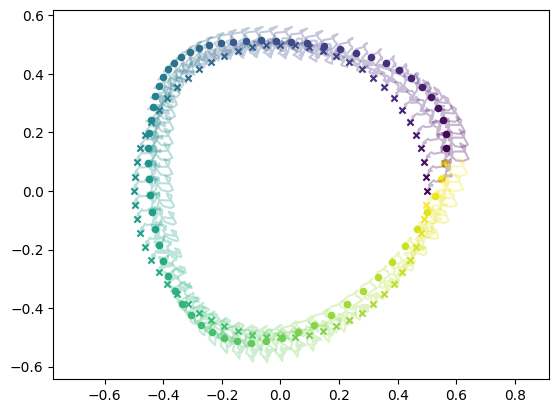

In [7]:
sample_idx = 3
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
for i in range(sde.n_samples):
    plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
    plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
    plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
plt.axis('equal')

In [8]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [32, 16, 8],
        "decoder_layer_dims": [8, 16, 32],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 8,
        "num_epochs": 100,
        "num_batches_per_epoch": 50,
        "learning_rate": 1e-3,
        "warmup_steps": 1000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0_flatten,
    setup_params=setup_params,
)

+------------------------------------------------+----------+-------+----------+-------+
| Name                                           | Shape    | Size  | Mean     | Std   |
+------------------------------------------------+----------+-------+----------+-------+
| Dense_0/Dense_0/bias                           | (8,)     | 8     | 0.0      | 0.0   |
| Dense_0/Dense_0/kernel                         | (8, 8)   | 64    | -0.0309  | 0.339 |
| Dense_1/Dense_0/bias                           | (16,)    | 16    | 0.0      | 0.0   |
| Dense_1/Dense_0/kernel                         | (32, 16) | 512   | -0.0083  | 0.214 |
| Downsample_0/BatchNorm_0/bias                  | (32,)    | 32    | 0.0      | 0.0   |
| Downsample_0/BatchNorm_0/scale                 | (32,)    | 32    | 1.0      | 0.0   |
| Downsample_0/Dense_0/Dense_0/bias              | (32,)    | 32    | 0.0      | 0.0   |
| Downsample_0/Dense_0/Dense_0/kernel            | (32, 32) | 1,024 | 0.00257  | 0.181 |
| Downsample_0/Dense_

Training: 100%|██████████| 100/100 [08:37<00:00,  5.17s/epoch, Epoch=100, loss=1.4321]


ST shape:  (64, 2)
X0 shape:  (4, 2)
XT shape:  (4, 2)
XT shape (Padded):  (64, 2)


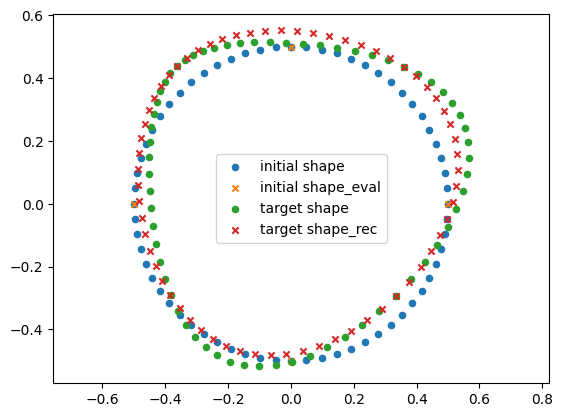

XT_flatten shape:  (8,)


In [9]:
ST = Ss[3, -1, :, :]
print("ST shape: ", ST.shape)
X0 = jnp.zeros((sde.n_bases, 2), dtype=jnp.complex64)
print("X0 shape: ", X0.shape)
XT_eval = ST - S0
XT = jnp.fft.fft(XT_eval, norm="ortho", n=sde.n_samples, axis=0)
XT = jnp.fft.fftshift(XT, axes=0)
XT = XT[(sde.n_samples-sde.n_bases)//2:(sde.n_samples+sde.n_bases)//2, :]
print("XT shape: ", XT.shape)
XT_pad = jnp.pad(XT, ((sde.n_padding, sde.n_padding), (0, 0)))
print("XT shape (Padded): ", XT_pad.shape) 
XT_pad = jnp.fft.ifftshift(XT_pad, axes=0)
XT_rec = jnp.fft.ifft(XT_pad, norm="ortho", n=sde.n_samples, axis=0).real
ST_rec = XT_rec + S0

with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(S0[:, 0], S0[:, 1], s=20, label='initial shape')
    plt.scatter(S0_eval[:, 0].real, S0_eval[:, 1].real, s=20, marker='x', label='initial shape_eval')
    plt.scatter(ST[:, 0], ST[:, 1], s=20, label='target shape')
    plt.scatter(ST_rec[:, 0], ST_rec[:, 1], s=20, marker='x', label='target shape_rec')
    plt.legend()
    plt.axis('equal')
    plt.show()

XT_flatten = jnp.concatenate((XT[:, 0], XT[:, 1]), axis=0)
print("XT_flatten shape: ", XT_flatten.shape)

In [10]:
@jax.jit
def score_p(val, time):
    score_output = score_p_state.apply_fn(
        {"params": score_p_state.params, "batch_stats": score_p_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0_flatten,
    terminal_val=XT_flatten,
    score_p=score_p,
    num_batches=4,
)

In [11]:
Xs_flatten = backward_brownian_bridge["trajectories"]
print("Xs_flatten shape: ", Xs_flatten.shape)
Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
print("Xs shape: ", Xs.shape)
Xs_pad = jnp.pad(Xs, pad_width=((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs shape (padded): ", Xs_pad.shape)
Xs_pad = jnp.fft.ifftshift(Xs_pad, axes=-2)
Xs_rec = jnp.fft.ifft(Xs_pad, norm="ortho", n=n_samples, axis=-2)
print("Xs_rec shape: ", Xs_rec.shape)

Ss = S0[None, None, :, :] + Xs_rec.real
print("Ss shape: ", Ss.shape)

Xs_flatten shape:  (4, 50, 8)
Xs shape:  (4, 50, 4, 2)
Xs shape (padded):  (4, 50, 64, 2)
Xs_rec shape:  (4, 50, 64, 2)
Ss shape:  (4, 50, 64, 2)


(-0.8767075359821319,
 0.8600987017154693,
 -0.6057202577590942,
 0.6765045881271362)

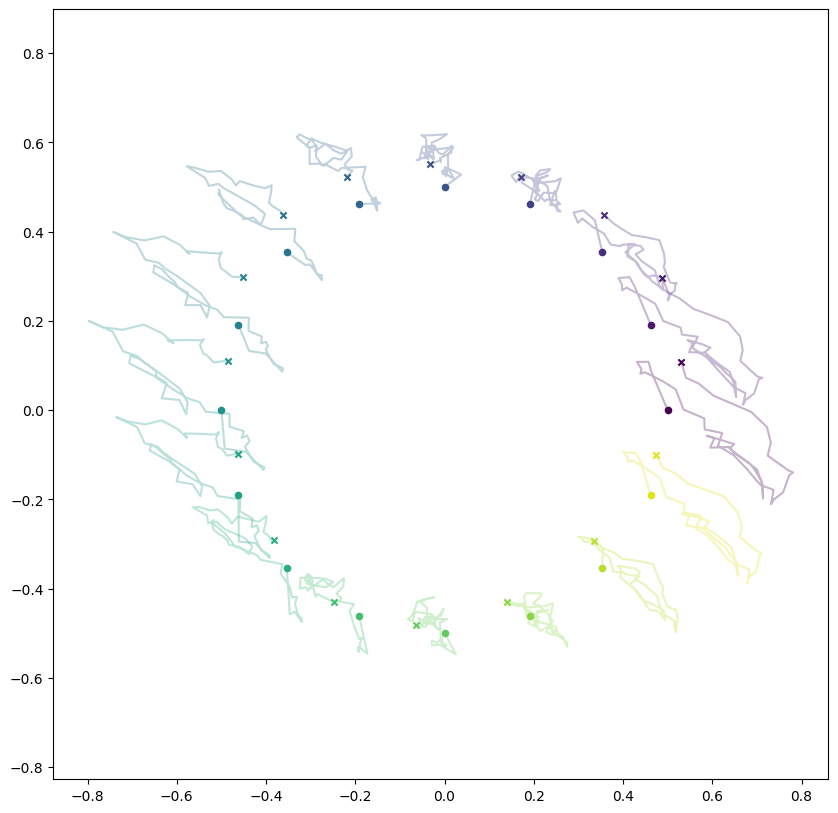

In [12]:
sample_idx = 2
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
plt.figure(figsize=(10, 10))
for i in jnp.arange(sde.n_samples)[::4]:
    plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
    plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
    plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
plt.axis('equal')

In [13]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [32, 16, 8],
        "decoder_layer_dims": [8, 16, 32],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 8,
        "num_epochs": 100,
        "num_batches_per_epoch": 50,
        "learning_rate": 1e-3,
        "warmup_steps": 1000,
    }
}

score_p_star_state = bridge.learn_p_star_score(
    initial_val=X0_flatten,
    terminal_val=XT_flatten,
    score_p=score_p,
    setup_params=setup_params,
)

+------------------------------------------------+----------+-------+----------+-------+
| Name                                           | Shape    | Size  | Mean     | Std   |
+------------------------------------------------+----------+-------+----------+-------+
| Dense_0/Dense_0/bias                           | (8,)     | 8     | 0.0      | 0.0   |
| Dense_0/Dense_0/kernel                         | (8, 8)   | 64    | -0.0309  | 0.339 |
| Dense_1/Dense_0/bias                           | (16,)    | 16    | 0.0      | 0.0   |
| Dense_1/Dense_0/kernel                         | (32, 16) | 512   | -0.0083  | 0.214 |
| Downsample_0/BatchNorm_0/bias                  | (32,)    | 32    | 0.0      | 0.0   |
| Downsample_0/BatchNorm_0/scale                 | (32,)    | 32    | 1.0      | 0.0   |
| Downsample_0/Dense_0/Dense_0/bias              | (32,)    | 32    | 0.0      | 0.0   |
| Downsample_0/Dense_0/Dense_0/kernel            | (32, 32) | 1,024 | 0.00257  | 0.181 |
| Downsample_0/Dense_

Training:   2%|▏         | 2/100 [01:20<1:05:46, 40.27s/epoch, Epoch=2, loss=2.3245]


KeyboardInterrupt: 